In [1]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

In [2]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(44)
sixteen = generate_random_map(16)
np.random.seed(44)
tvelve = generate_random_map(12)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "12x12": tvelve,
    "16x16": sixteen
}

In [3]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 10000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # all done
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [4]:
def q_learning(env, discount=0.9, total_episodes=1e5, alpha=0.1, decay_rate=None,
               min_epsilon=0.01):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    
    qtable = np.zeros((number_of_states, number_of_actions))
    learning_rate = alpha
    gamma = discount

    # exploration parameter
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    
    if not decay_rate:
        decay_rate = 1./total_episodes
    
    rewards = []
    for episode in range(int(total_episodes)):
        # reset the environment
        state = env.reset()
        step = 0
        done = False
        total_reward = 0
        while True:

            # choose an action a in the corrent world state
            exp_exp_tradeoff = random.uniform(0,1)

            # if greater than epsilon --> exploit
            if exp_exp_tradeoff > epsilon:
                b = qtable[state, :]
                action = np.random.choice(np.where(b == b.max())[0])
#                 action = np.argmax(qtable[state, :])
            # else choose exploration
            else:
                action = env.action_space.sample()

            # take action (a) and observe the outcome state (s') and reward (r)    
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            # update Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max(Q (s', a') - Q(s,a))]
            if not done:
                qtable[state, action] = qtable[state, action] + learning_rate*(reward + gamma*np.max(qtable[new_state, :]) - qtable[state, action])
            else:
                qtable[state, action] = qtable[state,action] + learning_rate*(reward - qtable[state,action])

            # change state
            state = new_state

            # is it Done
            if done:
                break
                
        # reduce epsilon 
        rewards.append(total_reward)
        epsilon = max(max_epsilon -  decay_rate * episode, min_epsilon) 
    #     print (epsilon)
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(total_episodes, time_spent))
    return np.argmax(qtable, axis=1), total_episodes, time_spent, qtable, rewards

In [5]:
def train_and_test_q_learning(env, discount=[0.9], total_episodes=[1e5], alphas=[0.1], decay_rates=[0.01], mute=False):
    
    min_epsilon = 0.01
    
    q_dict = {}
    for dis in discount:
        q_dict[dis] = {}
        for eps in total_episodes:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for dr in decay_rates:
                    q_dict[dis][eps][alpha][dr] = {}
                    
                    # run q_learning
                    q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning(env, dis, eps, alpha, dr, min_epsilon)
                    q_mrews, q_meps, _, __ = test_policy(env, q_policy)
                    q_dict[dis][eps][alpha][dr]["mean_reward"] = q_mrews
                    q_dict[dis][eps][alpha][dr]["mean_eps"] = q_meps
                    q_dict[dis][eps][alpha][dr]["q-table"] = q_table
                    q_dict[dis][eps][alpha][dr]["rewards"] = rewards 
                    q_dict[dis][eps][alpha][dr]["iteration"] = q_solve_iter
                    q_dict[dis][eps][alpha][dr]["time_spent"] = q_solve_time
                    q_dict[dis][eps][alpha][dr]["policy"] = q_policy
                    if not mute:
                        print("gamma: {} total_eps: {} lr: {}, dr: {}".format(dis, eps, alpha, dr))
                        print("Iteration: {} time: {}".format(q_solve_iter, q_solve_time))
                        print("Mean reward: {} - mean eps: {}".format(q_mrews, q_meps))
    return q_dict

In [6]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()


In [7]:
def dict_to_df(the_dict):
    the_df = pd.DataFrame(columns=["Discount Rate", "Training Episodes", "Learning Rate", 
                                   "Decay Rate", "Reward", "Time Spent"])
    for dis in the_dict:
        for eps in the_dict[dis]:
            for lr in the_dict[dis][eps]:
                for dr in the_dict[dis][eps][lr]:
                    rew = the_dict[dis][eps][lr][dr]["mean_reward"]
                    time_spent = the_dict[dis][eps][lr][dr]["time_spent"].total_seconds()
                    dic = {"Discount Rate": dis, "Training Episodes": eps, "Learning Rate":lr, 
                           "Decay Rate":dr, "Reward": rew, "Time Spent": time_spent}
                    the_df = the_df.append(dic, ignore_index=True)
    return the_df

In [8]:
import numpy as np
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [9]:
env = gym.make('FrozenLake-v0')
episodes = [1e4, 1e5, 1e6]
decays = [1e-6]

q_dict = train_and_test_q_learning(env, discount=[0.75, 0.9, 0.99, 0.9999], total_episodes=episodes,
                          alphas=[0.01, 0.1], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:03.061093 seconds
gamma: 0.75 total_eps: 10000.0 lr: 0.01, dr: 1e-06
Iteration: 10000.0 time: 0:00:03.061093
Mean reward: 0.524 - mean eps: 31.79
Solved in: 10000.0 episodes and 0:00:03.441689 seconds
gamma: 0.75 total_eps: 10000.0 lr: 0.1, dr: 1e-06
Iteration: 10000.0 time: 0:00:03.441689
Mean reward: 0.559 - mean eps: 35.937
Solved in: 100000.0 episodes and 0:00:36.508346 seconds
gamma: 0.75 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Iteration: 100000.0 time: 0:00:36.508346
Mean reward: 0.464 - mean eps: 27.587
Solved in: 100000.0 episodes and 0:00:34.573167 seconds
gamma: 0.75 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Iteration: 100000.0 time: 0:00:34.573167
Mean reward: 0.358 - mean eps: 23.946
Solved in: 1000000.0 episodes and 0:10:14.769365 seconds
gamma: 0.75 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Iteration: 1000000.0 time: 0:10:14.769365
Mean reward: 0.519 - mean eps: 30.625
Solved in: 1000000.0 episodes and 0:08:26.638435 seconds
gamma: 0.75 to

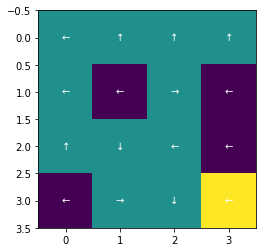

In [10]:
pol = q_dict[0.99][int(1e6)][0.1][1e-06]['policy']
see_policy(4, pol)

In [11]:
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict = train_and_test_q_learning(env, discount= [0.9999], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:24.848442 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:24.848442
Mean reward: 0.728 - mean eps: 43.573
Solved in: 10000.0 episodes and 0:00:04.060115 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:04.060115
Mean reward: 0.652 - mean eps: 44.711
Solved in: 10000.0 episodes and 0:00:04.899928 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:04.899928
Mean reward: 0.056 - mean eps: 8.08
Solved in: 10000.0 episodes and 0:00:03.963134 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:03.963134
Mean reward: 0.595 - mean eps: 36.082
Solved in: 100000.0 episodes and 0:03:45.943022 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:03:45.943022
Mean reward: 0.73 - mean eps: 41.396
Solved in: 100000.0 episodes and 0:01:34.700545 seconds
gamma: 0.9999 tot

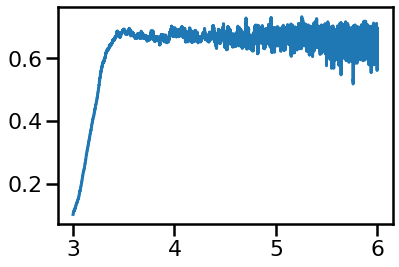

In [27]:
rews = q_dict[0.9999][int(1e6)][0.1][1e-03]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.set_context("poster")
sns.lineplot(np.log10(indices), rew_running)

[Text(0, 0.5, 'Reward'), Text(0.5, 0, 'Log iterations')]

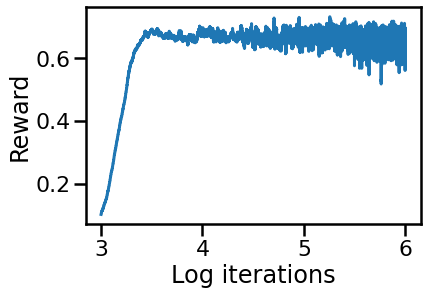

In [28]:
sns.set_context("poster")
ax=sns.lineplot(np.log10(indices), rew_running)
ax.set(xlabel="Log iterations", ylabel = "Reward")

[Text(0, 0.5, 'Reward'), Text(0.5, 0, 'Log iterations')]

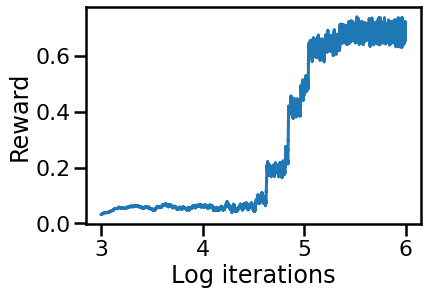

In [29]:
rews = q_dict[0.9999][int(1e6)][0.01][1e-03]['rewards']
run = 1000
rew_running = running_mean(rews, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.set_context("poster")
ax=sns.lineplot(np.log10(indices), rew_running)
ax.set(xlabel="Log iterations", ylabel = "Reward")

In [30]:
rews

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

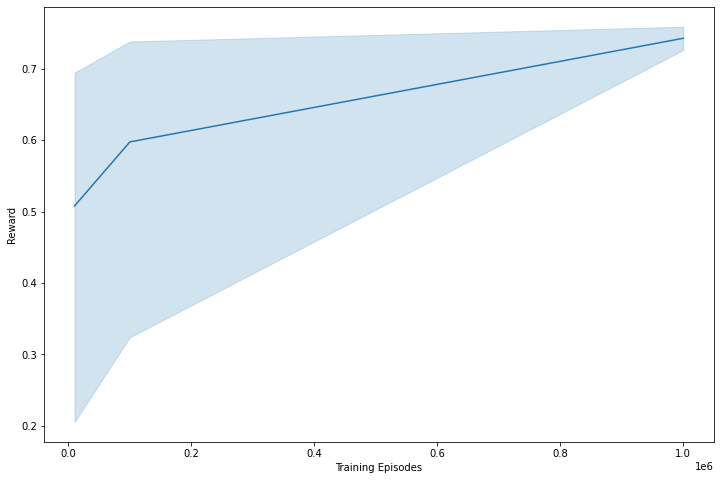

In [15]:
q4 = dict_to_df(q_dict)
# plt.figure(figsize=(12, 8))
pl = sns.lineplot(x="Training Episodes", y="Reward", data=q4)
pl.figure.set_figwidth(12)
pl.figure.set_figheight(8)

In [35]:
from tabulate import tabulate 
print(tabulate(q4, headers = 'keys', tablefmt = 'github'))

|    |   Discount Rate |   Training Episodes |   Learning Rate |   Decay Rate |   Reward |   Time Spent |
|----|-----------------|---------------------|-----------------|--------------|----------|--------------|
|  0 |          0.9999 |           10000     |            0.1  |        0.001 |    0.728 |     24.8484  |
|  1 |          0.9999 |           10000     |            0.1  |        1e-05 |    0.652 |      4.06011 |
|  2 |          0.9999 |           10000     |            0.01 |        0.001 |    0.056 |      4.89993 |
|  3 |          0.9999 |           10000     |            0.01 |        1e-05 |    0.595 |      3.96313 |
|  4 |          0.9999 |          100000     |            0.1  |        0.001 |    0.73  |    225.943   |
|  5 |          0.9999 |          100000     |            0.1  |        1e-05 |    0.741 |     94.7005  |
|  6 |          0.9999 |          100000     |            0.01 |        0.001 |    0.188 |    118.89    |
|  7 |          0.9999 |          100000     |

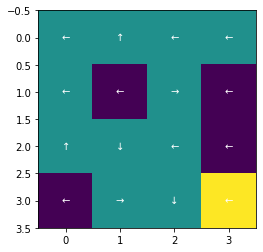

In [17]:
pol = q_dict[0.9999][int(1e6)][0.01][1e-03]['policy']
see_policy(4, pol)

## 16x16

In [18]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict16 = train_and_test_q_learning(env, discount= [0.9999], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 0:00:02.773234 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:02.773234
Mean reward: 0.0 - mean eps: 3.138
Solved in: 10000.0 episodes and 0:00:02.056606 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.056606
Mean reward: 0.0 - mean eps: 2.996
Solved in: 10000.0 episodes and 0:00:02.707683 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:02.707683
Mean reward: 0.0 - mean eps: 3.029
Solved in: 10000.0 episodes and 0:00:02.333301 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.333301
Mean reward: 0.0 - mean eps: 2.985
Solved in: 100000.0 episodes and 0:00:27.319331 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:00:27.319331
Mean reward: 0.0 - mean eps: 3.044
Solved in: 100000.0 episodes and 0:00:24.403165 seconds
gamma: 0.9999 total_eps: 1000

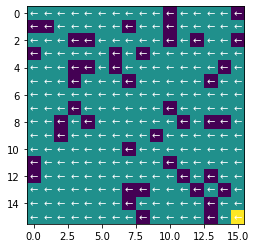

In [24]:
pol = q_dict16[0.9999][int(1e6)][0.01][1e-05]['policy']
see_policy(16, pol)

In [25]:
(q_dict16[0.9999][int(1e6)][0.1][1e-05]['q-table'] > 0).any()

False

In [34]:
q16 = dict_to_df(q_dict16)
 
print(tabulate(q16, headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤═════════════════╤═════════════════════╤═════════════════╤══════════════╤══════════╤══════════════╕
│    │   Discount Rate │   Training Episodes │   Learning Rate │   Decay Rate │   Reward │   Time Spent │
╞════╪═════════════════╪═════════════════════╪═════════════════╪══════════════╪══════════╪══════════════╡
│  0 │          0.9999 │           10000     │            0.1  │        0.001 │        0 │      2.77323 │
├────┼─────────────────┼─────────────────────┼─────────────────┼──────────────┼──────────┼──────────────┤
│  1 │          0.9999 │           10000     │            0.1  │        1e-05 │        0 │      2.05661 │
├────┼─────────────────┼─────────────────────┼─────────────────┼──────────────┼──────────┼──────────────┤
│  2 │          0.9999 │           10000     │            0.01 │        0.001 │        0 │      2.70768 │
├────┼─────────────────┼─────────────────────┼─────────────────┼──────────────┼──────────┼──────────────┤
│  3 │          0.9999 │           10000     │

In [22]:
import dill
dill.load_session('qlearning_all.db')

ModuleNotFoundError: No module named 'dill'